In [10]:
import numpy as np
import helper
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

/Users/ramazanbulut/.zshenv:1: permission denied: /Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home
Note: you may need to restart the kernel to use updated packages.
/Users/ramazanbulut/.zshenv:1: permission denied: /Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home
Note: you may need to restart the kernel to use updated packages.


In [176]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=512)
nmf = NMF(n_components=1024, init = 'random', tol=5e-3)


X_train = np.zeros((10000,4096))
for i in range(10000):
    image = Image.open("../input/3dshapes_train/{}.jpg".format(i)).convert('L')
    X_train[i] = np.array(image).flatten()
# X_train_nmf=nmf.fit_transform(X_train)
X_train=pca.fit_transform(X_train)

print('Train data NMF finished.')


X_test = np.zeros((1000, 4096))
for i in range(1000):
    image = Image.open("../input/3dshapes_test/{}.jpg".format(i)).convert('L')
    X_test[i] = np.array(image).flatten()
# X_test_nmf=nmf.fit_transform(X_test)
X_test=pca.transform(X_test)
print('Test data NMF finished.')

Train data NMF finished.
Test data NMF finished.


In [171]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

Y_train = np.load('../input/orientations_train.npy')
Y_test = np.load('../input/orientations_test.npy')
Y_test = le.fit_transform(Y_test)
Y_train = le.fit_transform(Y_train)

after tsne reduction shape: (10000, 2)


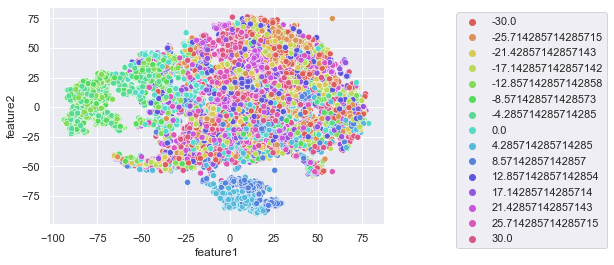

In [172]:
tsne=TSNE(n_components=2)
X_tsne=tsne.fit_transform(X_train_nmf)
print("after tsne reduction shape:",X_tsne.shape)

df = pd.DataFrame()
df["y"] = np.load('../input/orientations_train.npy')
df["feature1"] = X_tsne[:,0]
df["feature2"] = X_tsne[:,1]

sns.scatterplot(x="feature1", y="feature2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 15),legend="auto",
                data=df).legend(bbox_to_anchor= (1.2,1))

1.b

Softmax Funtion: $ softmax(z_i) = {exp(z_i) \over {\Sigma_{j=1}^{K} exp(z_i)}}$      $1\leq i \leq K $

Loss function: $L_{CE}(\hat{y},y) =\Sigma_{k=1}^{K} y_k log \hat y_k $ 			


we can write it like following equation because other classes will be zero thanks to One Hot Encoding

$ =-log\hat y_c $ 				

then (with One Hot Encoding)

$ = -log \hat p(y_c=1|x) $

($ y_c$ corresponds to correct class )

replace with softmax function

$= -log {exp(w_c\cdot x + b_k) \over {\Sigma_{j=1}^{K} exp(w_k\cdot x + b_k) }} $

and derive gradient of loss function (aka negative likelihood function)

$ {\partial L_{CE} \over \partial w_{k,i}} =-(y_k -\hat y_k)x_i $ 

$ =-(y_k-p(y_k=1|x))x_i $

replace our prediction with the softmax version

$ =-(y_k- {exp(w_k\cdot x + b_k) \over {\Sigma_{j=1}^{K} exp(w_j\cdot x + b_k) }} ) x_i $

$ = =-(y_k - softmax(\hat y_k))x_i $



References: https://web.stanford.edu/~jurafsky/slp3/5.pdf, https://web.stanford.edu/~jurafsky/slp3/7.pdf 

Subsections in references: 5.8 and 5.10 7.6


In [169]:
from sklearn.preprocessing import OneHotEncoder
OHE=OneHotEncoder(sparse=False)
from scipy.special import softmax
import numpy as np

def calculateLoss(x,y,w):
        z = np.float128(x @ w)
        z=-z
        n=x.shape[0]
        loss=1/n * (np.trace(x @ w @ y.T) + np.sum(np.log(np.sum(np.exp(z),axis=1))))
        return loss

def calculateGradient(x,y,w):
        y_star=softmax(-x@w,axis=1)
        n=x.shape[0]
        gd=1/n * (x.T @ (y-y_star)) #+ 2 * mu * w #regularization
        return gd 

def gradient_descent(X, Y, max_steps=5000, eta=0.1, loss_threshold=0.1):

	Y_onehot=OHE.fit_transform(Y.reshape(-1,1))
	W = np.zeros((X.shape[1], Y_onehot.shape[1]))
	step = 0
	while step < max_steps:
		step += 1
		gradient = calculateGradient(X, Y_onehot, W)
		W -= eta * gradient
		n_gradient=np.linalg.norm(gradient)
		if(n_gradient<loss_threshold):
			break
	return W, step

def predict (W ,X):
	Z = - X @ W 
	P = softmax(Z, axis=1)
	return np.argmax(P, axis=1) # reverse one hot encoding.

In [180]:
from sklearn.model_selection import KFold

def kFoldCrossValidation(X_train=X_train ,k=5, step_size=0.1):
        k_fold = KFold(k, shuffle=False)
        indices=k_fold.split(Y_train)
        j = 1
        for train, test in indices:
                miss = 0
                W, step = gradient_descent(X_train[train], Y_train[train], eta=step_size)
                prediction = predict(W, X_train[test])
                for i in range(0, len(prediction)):
                        if prediction[i] != Y_train[test][i]:
                                miss += 1
                print("For fold #{} number accuracy:\n# of steps:\t{}\nAccuracy:\t{}".format(j, step, 1 - miss/len(prediction)))
                j += 1

def testAccuracy(X_train = X_train, X_test=X_test, step_size=0.1):
        print(X_train.shape, X_test.shape)
        W, step = gradient_descent(X_train, Y_train, eta=step_size)
        prediction = predict(W, X_test)
        print(prediction.shape)
        miss = 0
        for i in range(0, len(prediction)):
                if prediction[i] != Y_test[i]:
                        miss += 1
        print("For full batch:\n# of steps:\t{}\nAccuracy:\t{}".format(step, 1 - miss/len(prediction)))
        

step_size_candidates = [0.001, 0.01, 0.1, 0.3]

for step_size in step_size_candidates:
        print("Step size: {}".format(step_size))
        kFoldCrossValidation(step_size=step_size)
        testAccuracy(step_size=step_size)
        print()



Step size: 0.001
For fold #1 number accuracy:
# of steps:	177
Accuracy:	0.9985
For fold #2 number accuracy:
# of steps:	196
Accuracy:	0.9985
For fold #3 number accuracy:
# of steps:	213
Accuracy:	0.997
For fold #4 number accuracy:
# of steps:	212
Accuracy:	0.9995
For fold #5 number accuracy:
# of steps:	231
Accuracy:	1.0
(10000, 512) (1000, 512)
(1000,)
For full batch:
# of steps:	312
Accuracy:	1.0

Step size: 0.01
For fold #1 number accuracy:
# of steps:	175
Accuracy:	0.996
For fold #2 number accuracy:
# of steps:	199
Accuracy:	0.999
For fold #3 number accuracy:
# of steps:	238
Accuracy:	0.9985
For fold #4 number accuracy:
# of steps:	220
Accuracy:	0.9995
For fold #5 number accuracy:
# of steps:	211
Accuracy:	0.9995
(10000, 512) (1000, 512)
(1000,)
For full batch:
# of steps:	314
Accuracy:	1.0

Step size: 0.1
For fold #1 number accuracy:
# of steps:	175
Accuracy:	0.9985
For fold #2 number accuracy:
# of steps:	195
Accuracy:	0.9985
For fold #3 number accuracy:
# of steps:	188
Accuracy:

| Step Size  | K-Fold Average Number of Steps | K-Fold Average Accuracy | Test Accuracy | Test Step Number |
| :- |:-:| :-:| :-: | -:|
| 0.001 | 205 | 0.9987 | 1.0|312 | 
| 0.01  | 208 | 0.9985 |1.0 |314 |
| 0.1   | 197 | 0.9987 *|0.998 |298 |
| 0.3   | 194 | 0.9986 |1.0 |345 | 